# 08 — Transformación Proyectiva (Homografía) en 2D

## Teoría (coordenadas homogéneas, matriz 3×3)

La **transformación proyectiva** (o **homografía**) mapea puntos de un plano a otro usando una matriz $( \mathbf{H} \in \mathbb{R}^{3\times 3} )$ definida **a escala** (hasta un factor).
En **coordenadas homogéneas**:
$
\begin{bmatrix}
x_2 \\ y_2 \\ w
\end{bmatrix}$
$=
\mathbf{H}$
$\begin{bmatrix}
x_1 \\ y_1 \\ 1
\end{bmatrix}$,
$\qquad
\mathbf{H}=$
$\begin{bmatrix}
h_{11} & h_{12} & h_{13} \\
h_{21} & h_{22} & h_{23} \\
h_{31} & h_{32} & h_{33}
\end{bmatrix}.
$

Para volver a coordenadas cartesianas:
$
x'_2 = \frac{x_2}{w}, \qquad y'_2 = \frac{y_2}{w}.
$

Una homografía está determinada (salvo escala) por **cuatro pares de puntos no colineales** (4 correspondencias punto a punto).
OpenCV provee:
- `cv2.getPerspectiveTransform(src_pts, dst_pts)` cuando damos **4 puntos** exactos.
- `cv2.findHomography(src_pts, dst_pts, method=RANSAC)` para datos con ruido/outliers.

La aplicación sobre una imagen se hace con:
- `cv2.warpPerspective(img, H, (W, H))`.


## Implementación en OpenCV

1. **Deformación proyectiva** controlada: moveremos las esquinas de la imagen para crear una vista "trapezoidal".  
2. **Rectificación** de un cuadrilátero interno: seleccionar una región y llevarla a un rectángulo (simulando *bird's-eye*).  


✅ Imagen guardada con puntos: C:\Users\rrm21\Documents\Vision_en_Robotica\dron_images\p1_con_puntos.png
✅ Imagen guardada con puntos: C:\Users\rrm21\Documents\Vision_en_Robotica\dron_images\p2_con_puntos.png
✅ Mosaico guardado en: C:\Users\rrm21\Documents\Vision_en_Robotica\dron_images\mosaico_1.png


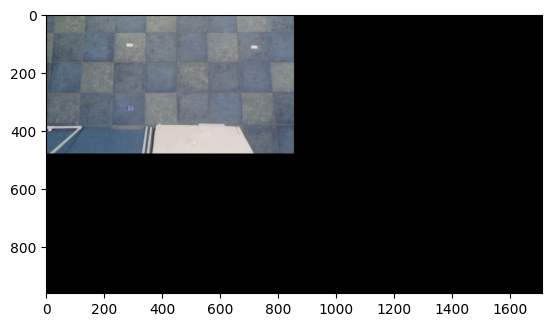

In [8]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt



# Carpeta de imágenes
img_dir = r"C:\Users\rrm21\Documents\Vision_en_Robotica\dron_images"

# Cargar imágenes
p1 = cv2.imread(os.path.join(img_dir, "p1.png"))
p2 = cv2.imread(os.path.join(img_dir, "p2.png"))

# ----------------------------
# 1. Definir puntos de referencia
# ----------------------------
# Esquinas de p2 (ejemplo ficticio)
pts_p2 = np.float32([[50,50], [450,50], [50,450], [450,450]])

# A dónde quieres que caigan en p1 (ejemplo ficticio)
pts_p1 = np.float32([[50,50], [450,50], [50,450], [450,450]])

# ----------------------------
# 2. Dibujar y guardar imágenes con puntos
# ----------------------------
def draw_points(img, points, name):
    img_copy = img.copy()
    for i, (x, y) in enumerate(points):
        cv2.circle(img_copy, (int(x), int(y)), 6, (0, 0, 255), -1)  # punto rojo
        cv2.putText(img_copy, str(i+1), (int(x)+10, int(y)-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
    out_path = os.path.join(img_dir, f"{name}_con_puntos.png")
    cv2.imwrite(out_path, img_copy)
    print(f"✅ Imagen guardada con puntos: {out_path}")

# Guardar p1 y p2 con sus puntos
draw_points(p1, pts_p1, "p1")
draw_points(p2, pts_p2, "p2")

# ----------------------------
# 3. Calcular transformación proyectiva
# ----------------------------
M = cv2.getPerspectiveTransform(pts_p2, pts_p1)

# Crear un lienzo grande
canvas_h = p1.shape[0] * 2
canvas_w = p1.shape[1] * 2
p2_warped = cv2.warpPerspective(p2, M, (canvas_w, canvas_h))

# ----------------------------
# 4. Crear mosaico y fusionar
# ----------------------------
mosaic = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)
mosaic[0:p1.shape[0], 0:p1.shape[1]] = p1

mask = p2_warped > 0
mosaic[mask] = p2_warped[mask]

# ----------------------------
# 5. Guardar mosaico
# ----------------------------
output_path = os.path.join(img_dir, "mosaico_1.png")
cv2.imwrite(output_path, mosaic)
print("✅ Mosaico guardado en:", output_path)

plt.imshow(mosaic);


### Ejemplo 1 — Deformación proyectiva de toda la imagen (mover esquinas)

Definimos 4 puntos **origen** (las esquinas) y 4 puntos **destino** (un trapecio). Usamos `getPerspectiveTransform` + `warpPerspective`.


### Ejemplo 2 — Rectificación de un cuadrilátero interno (*bird's‑eye* de una región)

Seleccionamos un **cuadrilátero** dentro de la imagen (simulando un plano inclinado) y lo mapeamos a un **rectángulo** de salida.
Esto es análogo a **rectificar un plano** (p. ej., el piso o una hoja vista en perspectiva).